## <p style="font-family: Arial; color: gold; font-weight: bold;">**update by Tom Tan in 2.1.2025** <br> Openshell version</p>

##### Based on Brittany C. Haas and Melissa A. Hardy's jupyter notebook for automated collection of molecular descriptors and post-processing (i.e., Boltzmann average, min/max values, etc.).

#### <p style="font-family: Arial; color: gold; font-weight: bold;">**Below cell installs the required packages.** </p>

In [1]:
!pip install --quiet cclib dbstep goodvibes ipykernel ipywidgets matplotlib morfeus-ml numpy openpyxl pandas pillow rdkit tabulate xlsxwriter


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# **1. Imports**

In [2]:
import os, re, io, glob
import pandas as pd
from PIL import Image
from matplotlib.colors import ColorConverter

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import ipywidgets as widgets

from helper_functions import (
    search_for_substructure_openshell,
    load_structures_from_cdxml,
    draw_grid_image,
    format_dict_print,
    plot_common_structures,
)

common_structure_folder = "1.common_structure"
log_files_folder = "2.log_files"
sdf_files_folder = "3.sdf_files"
temp_folder = "temp"
output_folder = "4.atom_mappings"

os.makedirs(common_structure_folder, exist_ok=True)
os.makedirs(log_files_folder, exist_ok=True)
os.makedirs(sdf_files_folder, exist_ok=True)
os.makedirs(temp_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# **2. Generate Atom Inputs Dataframe**

### **2.1 Load the sdf file for each conformers**

##### <p style="font-family: Arial; color: gold; font-weight: bold;"> &emsp;You should ran the 0.clean_setup_folders.ipynb notebook to copy the common structure, log and sdf files to the current folder. The file requirements are listed in that notebook as well.</p>
##### <p style="font-family: Arial; color: red; font-weight: bold;"> &emsp;The sdf converted by openbabel in the original gp notebook are VERY BAD for radical and anion species and often put the double bond in the wrong place (bad kekulization?) and need many manual correction later. </p>
##### &emsp;list all *.log files in the directory

In [3]:
# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
log_prefix = {}
log_file_list = glob.glob("*.log", root_dir=log_files_folder)
for file in log_file_list:
    key = re.search(r"^(\D+)\d+", file)
    if key and key.group(1) in log_prefix:
        log_prefix[key.group(1)].append(file)
    else:
        log_prefix[key.group(1)] = [file]
# sort the dict by name, using regex ^\D+(\d+) to match the number in the filename
for each in log_prefix:
    log_prefix[each].sort(key=lambda x: int(re.search(r"^\D+(\d+)", x).group(1)))
# sort the key of the dict
log_prefix = dict(sorted(log_prefix.items()))
format_dict_print(log_prefix)

"cinnoline":          ['cinnoline001_conf-1_openshell.log']
"imidazopyrazine":    ['imidazopyrazine001_conf-1_openshell.log']
"isoquinoline":       ['isoquinoline001_conf-1_openshell.log', 'isoquinoline002_conf-1_openshell.log']
"pyrazine":           ['pyrazine001_conf-1_openshell.log', 'pyrazine002_conf-1_openshell.log', 'pyrazine003_conf-1_openshell.log', 'pyrazine004_conf-2_openshell.log', 'pyrazine005_conf-1_openshell.log', 'pyrazine006_conf-1_openshell.log', 'pyrazine007_conf-1_openshell.log']
"pyrazolopyridine":   ['pyrazolopyridine001_conf-1_openshell.log']
"pyrazolopyrimidine": ['pyrazolopyrimidine001_conf-1_openshell.log']
"pyridazine":         ['pyridazine001_conf-2_openshell.log', 'pyridazine002_conf-1_openshell.log', 'pyridazine003_conf-1_openshell.log', 'pyridazine004_conf-1_openshell.log', 'pyridazine005_conf-1_openshell.log', 'pyridazine006_conf-1_openshell.log', 'pyridazine007_conf-1_openshell.log', 'pyridazine008_conf-1_openshell.log']
"pyridine":           ['pyridine0

##### &emsp;generate log_ids_prefix.txt for each prefix by writing all log filename into a single file name log_ids_ + prefix + .txt

In [4]:
# generate log_ids_prefix.txt for each prefix, save to temp folder
output_file_prefix = "log_ids_"
for key in log_prefix:
    with open(temp_folder + os.sep + output_file_prefix + key + ".txt", "w") as f:
        for item in log_prefix[key]:
            f.write("%s\n" % item)

##### &emsp;list all sdf files in the directory, pipe content of those with a common prefix to a file name molecules_prefix.sdf

In [5]:
# we will first grep all the prefix, use regular expression to match all non-digit characters from the start of the filename
# the key will be the prefix, and the value will be a list of all the files with that prefix
sdf_prefix = {}
log_file_list = glob.glob("*.sdf", root_dir=sdf_files_folder)
for file in log_file_list:
    key = re.search(r"^(\D+)\d+", file)
    # check this against the key of prefix dictionary, if not present, skip
    if key and key.group(1) in log_prefix:
        if key.group(1) in sdf_prefix:
            sdf_prefix[key.group(1)].append(file)
        else:
            sdf_prefix[key.group(1)] = [file]

# sort the dict by name, using regex ^\D+(\d+) to match the number in the filename
for each in sdf_prefix:
    sdf_prefix[each].sort(key=lambda x: int(re.search(r"^\D+(\d+)", x).group(1)))
# sort the key of the dict
sdf_prefix = dict(sorted(sdf_prefix.items()))

format_dict_print(sdf_prefix)

# read the sdf files, pipe their contents to a single file named molecules_prefix.sdf
output_file_prefix = "molecules_"
for key in sdf_prefix:
    with open(temp_folder + os.sep + output_file_prefix + key + ".sdf", "w") as f:
        for sdf_file in sdf_prefix[key]:
            with open(sdf_files_folder + os.sep + sdf_file, "r") as f2:
                f.write(f2.read())
            # print(f"pipe {sdf_file} -> {output_file_prefix + key}.sdf")

"cinnoline":          ['cinnoline001_conf-1_openshell.sdf']
"imidazopyrazine":    ['imidazopyrazine001_conf-1_openshell.sdf']
"isoquinoline":       ['isoquinoline001_conf-1_openshell.sdf', 'isoquinoline002_conf-1_openshell.sdf']
"pyrazine":           ['pyrazine001_conf-1_openshell.sdf', 'pyrazine002_conf-1_openshell.sdf', 'pyrazine003_conf-1_openshell.sdf', 'pyrazine004_conf-2_openshell.sdf', 'pyrazine005_conf-1_openshell.sdf', 'pyrazine006_conf-1_openshell.sdf', 'pyrazine007_conf-1_openshell.sdf']
"pyrazolopyridine":   ['pyrazolopyridine001_conf-1_openshell.sdf']
"pyrazolopyrimidine": ['pyrazolopyrimidine001_conf-1_openshell.sdf']
"pyridazine":         ['pyridazine001_conf-2_openshell.sdf', 'pyridazine002_conf-1_openshell.sdf', 'pyridazine003_conf-1_openshell.sdf', 'pyridazine004_conf-1_openshell.sdf', 'pyridazine005_conf-1_openshell.sdf', 'pyridazine006_conf-1_openshell.sdf', 'pyridazine007_conf-1_openshell.sdf', 'pyridazine008_conf-1_openshell.sdf']
"pyridine":           ['pyridine0

***
# **3.Define SMARTS substructure**

### <p style="font-family: Arial; color: gold"> Draw the common substructure (with general atoms) in Chemdraw and copy as SMILES (this will generate a SMARTS string), edit the common_structure_list.

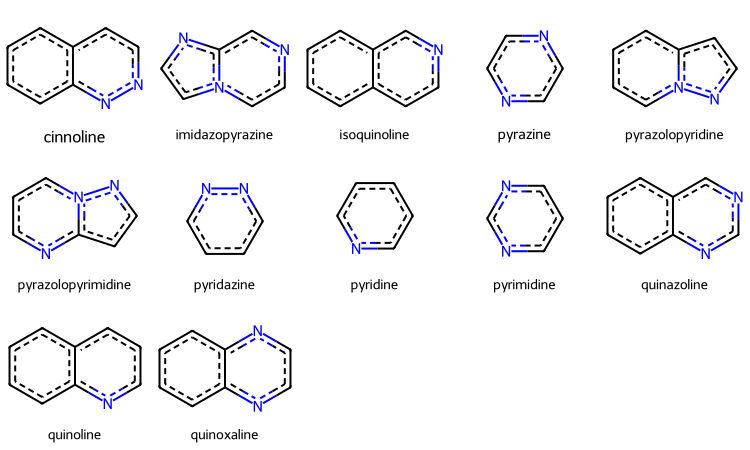

In [6]:
common_structure_list = load_structures_from_cdxml(root_dir=common_structure_folder)
display(plot_common_structures(common_structure_list))

## **3.1 Generate preliminary dataframe**
#### &emsp; This will generate **common_structure_ + prefix .png** in the **temp** folder with the common structure highlight and labeled. <br> &emsp; This label is the same as in GaussView so you don't need to use GaussView anymore. <br> &emsp; it will output a dataframe mapping the common structure atom to the corresponding atom index in GaussView for easier atom reassignment.
#### <p style="font-family: Arial; color: red; font-weight: bold;"> &emsp; !!!Be aware: Atom label was added in each cell for easier atom reassignment. For example, a cell change from just a single number from 7 to C7. <br> &emsp;You might need to adjust you code if you are only expecting number in each cell</p>

#### <p style="font-family: Arial; color: gold; font-weight: bold;"> Below cell search for the common structure and find the corresponding atom index for benzylic carbon, hydrogen and ipso carbon. <br>These structure search are best done with SDF file from the conformational search not from the converted sdf files using openbabel with the log output (not tested, use with your own risk).

In [7]:
# load the combined sdf file using SDMolSupplier
all_compounds_list = {}
for prefix in log_prefix:
    all_compounds_list[prefix] = Chem.SDMolSupplier(
        temp_folder + os.sep + "molecules_" + prefix + ".sdf", removeHs=False
    )
# molecules.sdf is generated with the instructions above
# it is a single sdf that contains all the structures/atom numbers etc. for every molecule we will analyze

mappped_df = {}
for prefix in log_prefix:
    mappped_df[prefix] = search_for_substructure_openshell(
        temp_folder=temp_folder,
        all_compounds=all_compounds_list[prefix],
        common_structure=common_structure_list[prefix],
        prefix=prefix,
    )
    display(mappped_df[prefix])

,log_name,0,1,2,3,4,5,6,7,8,9,10
0,cinnoline001_conf-1_openshell,C12,C6,N5,N4,C3,C7,C8,C10,C11,C2,C1


,log_name,0,1,2,3,4,5,6,7,8,9
0,imidazopyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C8,C9,N11,C2,C1


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,isoquinoline001_conf-1_openshell,C9,C8,C7,C6,C12,C10,C3,N4,C5,C2,C1
1,isoquinoline002_conf-1_openshell,C9,C10,C11,C12,C6,C7,C5,C4,N3,C2,C1


,log_name,0,1,2,3,4,5,6
0,pyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C2,C1
1,pyrazine002_conf-1_openshell,C7,N8,C9,C10,N11,C6,C5
2,pyrazine003_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
3,pyrazine004_conf-2_openshell,C6,C13,N12,C10,N7,C8,C9
4,pyrazine005_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
5,pyrazine006_conf-1_openshell,C8,C14,N13,C12,N9,C10,C11
6,pyrazine007_conf-1_openshell,C5,C6,N7,C10,N11,C8,C9


,log_name,0,1,2,3,4,5,6,7,8,9
0,pyrazolopyridine001_conf-1_openshell,C3,C4,C5,C6,C7,C9,N10,N11,C2,C1


,log_name,0,1,2,3,4,5,6,7,8,9
0,pyrazolopyrimidine001_conf-1_openshell,C5,C6,N9,N10,C11,C12,C13,N14,C7,C8


,log_name,0,1,2,3,4,5,6
0,pyridazine001_conf-2_openshell,C15,C16,C17,N18,N19,C14,C11
1,pyridazine002_conf-1_openshell,C5,C6,C9,N11,N12,C7,C8
2,pyridazine003_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
3,pyridazine004_conf-1_openshell,C5,C6,C7,N9,N10,C4,C2
4,pyridazine005_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
5,pyridazine006_conf-1_openshell,C3,C4,C5,N7,N8,C2,C1
6,pyridazine007_conf-1_openshell,C3,C4,C5,N8,N9,C6,C7
7,pyridazine008_conf-1_openshell,C5,C10,C8,N7,N6,C11,C12


,log_name,0,1,2,3,4,5,6
0,pyridine001_conf-2_openshell,C2,C7,N6,C4,C3,C5,C8
1,pyridine002_conf-8_openshell,C14,N13,C11,C10,C9,C8,C7
2,pyridine003_conf-7_openshell,C16,N15,C13,C12,C11,C10,C9
3,pyridine004_conf-1_openshell,C2,C3,N4,C5,C6,C11,C10
4,pyridine005_conf-1_openshell,C3,N6,C7,C8,C10,C4,C5
...,...,...,...,...,...,...,...,...
140,pyridine141_conf-1_openshell,C3,N8,C7,C5,C4,C2,C1
141,pyridine142_conf-2_openshell,C3,N9,C8,C5,C4,C2,C1
142,pyridine143_conf-1_openshell,C3,N9,C8,C5,C4,C2,C1
143,pyridine144_conf-1_openshell,C3,N7,C6,C5,C4,C2,C1


,log_name,0,1,2,3,4,5,6
0,pyrimidine001_conf-1_openshell,C9,N3,C4,N6,C7,C2,C1
1,pyrimidine002_conf-1_openshell,C6,N11,C9,N8,C7,C12,C13
2,pyrimidine003_conf-1_openshell,C5,C4,N11,C9,N8,C6,C7
3,pyrimidine004_conf-2_openshell,C3,C2,N15,N6,C4,C7,C8
4,pyrimidine005_conf-1_openshell,C6,C5,N12,C10,N9,C7,C8
5,pyrimidine006_conf-1_openshell,C5,N4,C3,N22,C21,C7,C8
6,pyrimidine007_conf-2_openshell,C7,C6,N13,C11,N10,C8,C9
7,pyrimidine008_conf-2_openshell,C5,N6,C7,N9,C10,C4,C3
8,pyrimidine009_conf-1_openshell,C9,N8,C6,N5,C4,C3,C2
9,pyrimidine010_conf-1_openshell,C18,N17,C5,N4,C3,C2,C1


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,quinazoline001_conf-8_openshell,C3,C26,N27,C28,N29,C7,C6,C5,C4,C2,C1
1,quinazoline002_conf-2_openshell,C13,C7,N6,C5,N4,C8,C9,C10,C12,C3,C2
2,quinazoline003_conf-1_openshell,C6,C11,N12,N3,C4,C10,C9,C8,C7,C2,C1
3,quinazoline004_conf-1_openshell,C6,C13,N14,N3,C4,C12,C10,C8,C7,C2,C1
4,quinazoline005_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
5,quinazoline006_conf-1_openshell,C12,C7,N6,C4,N3,C8,C9,C10,C11,C2,C1
6,quinazoline007_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
7,quinazoline008_conf-1_openshell,C7,C14,N13,C11,N10,C3,C4,C5,C6,C8,C9


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,quinoline001_conf-1_openshell,C15,C8,N9,C12,C13,C6,C5,C4,C3,C10,C11
1,quinoline002_conf-1_openshell,C11,C5,N6,C9,C10,C4,C3,C13,C12,C7,C8
2,quinoline003_conf-1_openshell,C12,C7,N6,C4,C3,C8,C9,C10,C11,C2,C1
3,quinoline004_conf-1_openshell,C7,C6,N5,C3,C4,C11,C10,C9,C8,C2,C1
4,quinoline005_conf-1_openshell,C6,C11,N12,C3,C4,C10,C9,C8,C7,C2,C1
5,quinoline006_conf-1_openshell,C4,C9,N10,C11,C3,C8,C7,C6,C5,C2,C1
6,quinoline007_conf-1_openshell,C14,C13,N12,C3,C4,C19,C18,C16,C15,C2,C1
7,quinoline008_conf-1_openshell,C6,C7,N4,C3,C5,C8,C16,C18,C19,C2,C1
8,quinoline009_conf-1_openshell,C8,C13,N14,C6,C7,C12,C11,C10,C9,C15,C16
9,quinoline010_conf-1_openshell,C6,C13,N14,C3,C4,C11,C10,C8,C7,C2,C1


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,quinoxaline001_conf-1_openshell,C4,C9,N10,C11,N3,C8,C7,C6,C5,C2,C1
1,quinoxaline002_conf-9_openshell,C6,C7,N4,C3,N5,C8,C9,C10,C11,C2,C1


<Figure size 3000x600 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x17400 with 0 Axes>

<Figure size 3000x3600 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x6000 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

## **3.2 Reassign atom labels**

##### Check the preliminary dataframe displayed above and the common_structure_prefix.png. You will see that the same common structure atom is labeled differently in each molecule (usually the same in each conformers). We need to address this by map atoms in the common structure to a new label that is consistent across all molecules.
##### Run the follow cell, for each prefix it will automatically map the common structure atoms to a new label that is consistent for the atoms of interest.

### <p style="font-family: Arial; color: yellow; font-weight: bold;"> last item in the matchlist is the benzylic carbon, the second last is the ipso carbon, the rest are the ring atoms <p>

### <p style="font-family: Arial; color: yellow; font-weight: bold;">benzylic carbon is renamed to C1, ipso carbon to C2, other atoms are are incremented from 2 <p>

In [8]:
# manually fixing pyrmd4_conf-1_anion in pyrmd
# print("Before fixing:")
# display(mappped_df["pyrmd"].loc[4])

# manually fixing pyrmd4_conf-1_anion in pyrmd
# Modify the row manually (row index 4)
# print("After fixing:")
# mappped_df["pyrmd"].loc[4] = [
#     "pyrmd4_conf-1_anion", "C5", "N12", "C7", "C11", "N10", "C3", "C2", "H16"
# ]
# display(mappped_df["pyrmd"].loc[4])

### <p style="font-family: Arial; color: red; font-weight: bold;"> You might need to manually assign atom labels like above if the follow cell raise exception <p>

In [9]:
# go through each dataframe in mappped_df, drop row with None
for key in mappped_df:
    # check if there is any invalid value in a row, print a warning
    invalid_rows = mappped_df[key].isnull().any(axis=1)
    if invalid_rows.any():
        print(f"Warning: invalid value in {key}, content: {mappped_df[key][invalid_rows]}")
        raise ValueError("Invalid value in the dataframe")
    else:
        print(f"No invalid value in prefix {key}")

No invalid value in prefix cinnoline
No invalid value in prefix imidazopyrazine
No invalid value in prefix isoquinoline
No invalid value in prefix pyrazine
No invalid value in prefix pyrazolopyridine
No invalid value in prefix pyrazolopyrimidine
No invalid value in prefix pyridazine
No invalid value in prefix pyridine
No invalid value in prefix pyrimidine
No invalid value in prefix quinazoline
No invalid value in prefix quinoline
No invalid value in prefix quinoxaline


In [10]:
# a example of the atom_labels, this is not used in the code
atom_labels = {
    "log_name": "log_name",
    0: "C4",
    1: "C5",
    2: "N1",
    3: "C1",
    4: "C2",
    5: "C3",
}

# this is a mapping from original atom number to the new atom label
atom_label_mappings = {}
atom_label_mappings_pandas = {}
display_buttons = {}

for prefix in log_prefix:
    atom_labels = {}
    print(f"Mapping for prefix '{prefix}':")
    # Display the DataFrame to the user
    display(mappped_df[prefix])

    # rename the columns to atom labels
    index_counter = 3  # keep a counter for the atom labels
    atom_label_mappings_pandas[prefix] = mappped_df[prefix].copy()
    atom_label_mappings[prefix] = {}

    # last item in the matchlist is the benzylic carbon, the second last is the ipso carbon
    # the rest are the ring atoms
    # we will rename hydrogen atoms first, then the benzylic carbon, then the ipso carbon, then the ring atoms
    # rename the last column to C1
    atom_label_mappings[prefix][atom_label_mappings_pandas[prefix].columns[-1]] = "C1"
    atom_label_mappings_pandas[prefix].rename(
        columns={atom_label_mappings_pandas[prefix].columns[-1]: "C1"}, inplace=True
    )
    # rename the second last column to C2
    atom_label_mappings[prefix][atom_label_mappings_pandas[prefix].columns[-2]] = "C2"
    atom_label_mappings_pandas[prefix].rename(
        columns={atom_label_mappings_pandas[prefix].columns[-2]: "C2"}, inplace=True
    )

    # now deal with the ring atoms, using the counter, we just need to make sure the number is unique and keep the atom symbol
    # ignore the first column which is the log_name
    for col in atom_label_mappings_pandas[prefix].columns[1:-2]:
        if col == "log_name":
            continue
        # find the cell content
        col_content = atom_label_mappings_pandas[prefix][col][0]
        # find the atom symbol
        atom_symbol = re.findall(r"[a-zA-Z]+", col_content)[0]
        renamed_col = atom_symbol + str(index_counter)
        # rename the column
        atom_label_mappings_pandas[prefix].rename(
            columns={col: renamed_col}, inplace=True
        )
        atom_label_mappings[prefix][col] = renamed_col
        # increment the counter
        index_counter += 1

    print(f"RENAMED Mapping for prefix '{prefix}' (The column name should changed):")
    display(atom_label_mappings_pandas[prefix])

    img_list = []

    # at the same time, for each row, load the molecule from the sdf file, add the atom labels based on the atom_labels_dict and highlight the substructure
    for index, row in mappped_df[prefix].iterrows():
        log_file = sdf_files_folder + os.sep + row["log_name"] + ".sdf"
        molecule = Chem.SDMolSupplier(log_file, removeHs=False)[0]
        Chem.rdDepictor.Compute2DCoords(molecule)

        highlight_atoms = []

        # the header will be the new atom labels, the cell content is the 'atom symbol + 1-indexed atom number'
        for col in atom_label_mappings_pandas[prefix]:
            if col == "log_name":
                continue
            atom_num = atom_label_mappings_pandas[prefix][col][index]
            # parse the atom number to get the atom index
            atom_num = int(re.findall(r"\d+", atom_num)[0]) - 1
            highlight_atoms.append(atom_num)
            molecule.GetAtomWithIdx(atom_num).SetProp("atomLabel", col)
        # Prepare the highlight color dictionary
        highlight_colors = {}
        for atom in highlight_atoms[:-2]:
            highlight_colors[atom] = ColorConverter().to_rgba("Pink", alpha=0.8)
        for atom in highlight_atoms[-2:-1]:
            highlight_colors[atom] = ColorConverter().to_rgba("Gold", alpha=0.8)
        for atom in highlight_atoms[-1:]:
            highlight_colors[atom] = ColorConverter().to_rgba("Green", alpha=0.8)

        # Create a drawer
        drawer = Chem.Draw.rdMolDraw2D.MolDraw2DCairo(
            600, 600
        )  # Use Cairo backend for drawing
        drawer.drawOptions().continuousHighlight = True
        # Prepare highlight dictionary
        drawer.DrawMolecule(
            molecule,
            highlightAtoms=highlight_atoms,
            highlightAtomColors=highlight_colors,
        )
        drawer.FinishDrawing()

        png_data = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(png_data))
        img_list.append(img)

    draw_grid_image(
        temp_folder=temp_folder,
        img_list=img_list,
        title_list=mappped_df[prefix]["log_name"],
        num_Cols=5,
        save_image_prefix="common_structure_reassigned_",
        item_suffix=prefix,
    )

print("Mapping dictionary:")
format_dict_print(atom_label_mappings)

Mapping for prefix 'cinnoline':


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,cinnoline001_conf-1_openshell,C12,C6,N5,N4,C3,C7,C8,C10,C11,C2,C1


RENAMED Mapping for prefix 'cinnoline' (The column name should changed):


,log_name,C3,C4,N5,N6,C7,C8,C9,C10,C11,C2,C1
0,cinnoline001_conf-1_openshell,C12,C6,N5,N4,C3,C7,C8,C10,C11,C2,C1


Mapping for prefix 'imidazopyrazine':


,log_name,0,1,2,3,4,5,6,7,8,9
0,imidazopyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C8,C9,N11,C2,C1


RENAMED Mapping for prefix 'imidazopyrazine' (The column name should changed):


,log_name,C3,N4,C5,C6,N7,C8,C9,N10,C2,C1
0,imidazopyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C8,C9,N11,C2,C1


Mapping for prefix 'isoquinoline':


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,isoquinoline001_conf-1_openshell,C9,C8,C7,C6,C12,C10,C3,N4,C5,C2,C1
1,isoquinoline002_conf-1_openshell,C9,C10,C11,C12,C6,C7,C5,C4,N3,C2,C1


RENAMED Mapping for prefix 'isoquinoline' (The column name should changed):


,log_name,C3,C4,C5,C6,C7,C8,C9,N10,C11,C2,C1
0,isoquinoline001_conf-1_openshell,C9,C8,C7,C6,C12,C10,C3,N4,C5,C2,C1
1,isoquinoline002_conf-1_openshell,C9,C10,C11,C12,C6,C7,C5,C4,N3,C2,C1


Mapping for prefix 'pyrazine':


,log_name,0,1,2,3,4,5,6
0,pyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C2,C1
1,pyrazine002_conf-1_openshell,C7,N8,C9,C10,N11,C6,C5
2,pyrazine003_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
3,pyrazine004_conf-2_openshell,C6,C13,N12,C10,N7,C8,C9
4,pyrazine005_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
5,pyrazine006_conf-1_openshell,C8,C14,N13,C12,N9,C10,C11
6,pyrazine007_conf-1_openshell,C5,C6,N7,C10,N11,C8,C9


RENAMED Mapping for prefix 'pyrazine' (The column name should changed):


,log_name,C3,N4,C5,C6,N7,C2,C1
0,pyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C2,C1
1,pyrazine002_conf-1_openshell,C7,N8,C9,C10,N11,C6,C5
2,pyrazine003_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
3,pyrazine004_conf-2_openshell,C6,C13,N12,C10,N7,C8,C9
4,pyrazine005_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
5,pyrazine006_conf-1_openshell,C8,C14,N13,C12,N9,C10,C11
6,pyrazine007_conf-1_openshell,C5,C6,N7,C10,N11,C8,C9


Mapping for prefix 'pyrazolopyridine':


,log_name,0,1,2,3,4,5,6,7,8,9
0,pyrazolopyridine001_conf-1_openshell,C3,C4,C5,C6,C7,C9,N10,N11,C2,C1


RENAMED Mapping for prefix 'pyrazolopyridine' (The column name should changed):


,log_name,C3,C4,C5,C6,C7,C8,N9,N10,C2,C1
0,pyrazolopyridine001_conf-1_openshell,C3,C4,C5,C6,C7,C9,N10,N11,C2,C1


Mapping for prefix 'pyrazolopyrimidine':


,log_name,0,1,2,3,4,5,6,7,8,9
0,pyrazolopyrimidine001_conf-1_openshell,C5,C6,N9,N10,C11,C12,C13,N14,C7,C8


RENAMED Mapping for prefix 'pyrazolopyrimidine' (The column name should changed):


,log_name,C3,C4,N5,N6,C7,C8,C9,N10,C2,C1
0,pyrazolopyrimidine001_conf-1_openshell,C5,C6,N9,N10,C11,C12,C13,N14,C7,C8


Mapping for prefix 'pyridazine':


,log_name,0,1,2,3,4,5,6
0,pyridazine001_conf-2_openshell,C15,C16,C17,N18,N19,C14,C11
1,pyridazine002_conf-1_openshell,C5,C6,C9,N11,N12,C7,C8
2,pyridazine003_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
3,pyridazine004_conf-1_openshell,C5,C6,C7,N9,N10,C4,C2
4,pyridazine005_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
5,pyridazine006_conf-1_openshell,C3,C4,C5,N7,N8,C2,C1
6,pyridazine007_conf-1_openshell,C3,C4,C5,N8,N9,C6,C7
7,pyridazine008_conf-1_openshell,C5,C10,C8,N7,N6,C11,C12


RENAMED Mapping for prefix 'pyridazine' (The column name should changed):


,log_name,C3,C4,C5,N6,N7,C2,C1
0,pyridazine001_conf-2_openshell,C15,C16,C17,N18,N19,C14,C11
1,pyridazine002_conf-1_openshell,C5,C6,C9,N11,N12,C7,C8
2,pyridazine003_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
3,pyridazine004_conf-1_openshell,C5,C6,C7,N9,N10,C4,C2
4,pyridazine005_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
5,pyridazine006_conf-1_openshell,C3,C4,C5,N7,N8,C2,C1
6,pyridazine007_conf-1_openshell,C3,C4,C5,N8,N9,C6,C7
7,pyridazine008_conf-1_openshell,C5,C10,C8,N7,N6,C11,C12


Mapping for prefix 'pyridine':


,log_name,0,1,2,3,4,5,6
0,pyridine001_conf-2_openshell,C2,C7,N6,C4,C3,C5,C8
1,pyridine002_conf-8_openshell,C14,N13,C11,C10,C9,C8,C7
2,pyridine003_conf-7_openshell,C16,N15,C13,C12,C11,C10,C9
3,pyridine004_conf-1_openshell,C2,C3,N4,C5,C6,C11,C10
4,pyridine005_conf-1_openshell,C3,N6,C7,C8,C10,C4,C5
...,...,...,...,...,...,...,...,...
140,pyridine141_conf-1_openshell,C3,N8,C7,C5,C4,C2,C1
141,pyridine142_conf-2_openshell,C3,N9,C8,C5,C4,C2,C1
142,pyridine143_conf-1_openshell,C3,N9,C8,C5,C4,C2,C1
143,pyridine144_conf-1_openshell,C3,N7,C6,C5,C4,C2,C1


RENAMED Mapping for prefix 'pyridine' (The column name should changed):


,log_name,C3,C4,N5,C6,C7,C2,C1
0,pyridine001_conf-2_openshell,C2,C7,N6,C4,C3,C5,C8
1,pyridine002_conf-8_openshell,C14,N13,C11,C10,C9,C8,C7
2,pyridine003_conf-7_openshell,C16,N15,C13,C12,C11,C10,C9
3,pyridine004_conf-1_openshell,C2,C3,N4,C5,C6,C11,C10
4,pyridine005_conf-1_openshell,C3,N6,C7,C8,C10,C4,C5
...,...,...,...,...,...,...,...,...
140,pyridine141_conf-1_openshell,C3,N8,C7,C5,C4,C2,C1
141,pyridine142_conf-2_openshell,C3,N9,C8,C5,C4,C2,C1
142,pyridine143_conf-1_openshell,C3,N9,C8,C5,C4,C2,C1
143,pyridine144_conf-1_openshell,C3,N7,C6,C5,C4,C2,C1


Mapping for prefix 'pyrimidine':


,log_name,0,1,2,3,4,5,6
0,pyrimidine001_conf-1_openshell,C9,N3,C4,N6,C7,C2,C1
1,pyrimidine002_conf-1_openshell,C6,N11,C9,N8,C7,C12,C13
2,pyrimidine003_conf-1_openshell,C5,C4,N11,C9,N8,C6,C7
3,pyrimidine004_conf-2_openshell,C3,C2,N15,N6,C4,C7,C8
4,pyrimidine005_conf-1_openshell,C6,C5,N12,C10,N9,C7,C8
5,pyrimidine006_conf-1_openshell,C5,N4,C3,N22,C21,C7,C8
6,pyrimidine007_conf-2_openshell,C7,C6,N13,C11,N10,C8,C9
7,pyrimidine008_conf-2_openshell,C5,N6,C7,N9,C10,C4,C3
8,pyrimidine009_conf-1_openshell,C9,N8,C6,N5,C4,C3,C2
9,pyrimidine010_conf-1_openshell,C18,N17,C5,N4,C3,C2,C1


RENAMED Mapping for prefix 'pyrimidine' (The column name should changed):


,log_name,C3,N4,C5,N6,C7,C2,C1
0,pyrimidine001_conf-1_openshell,C9,N3,C4,N6,C7,C2,C1
1,pyrimidine002_conf-1_openshell,C6,N11,C9,N8,C7,C12,C13
2,pyrimidine003_conf-1_openshell,C5,C4,N11,C9,N8,C6,C7
3,pyrimidine004_conf-2_openshell,C3,C2,N15,N6,C4,C7,C8
4,pyrimidine005_conf-1_openshell,C6,C5,N12,C10,N9,C7,C8
5,pyrimidine006_conf-1_openshell,C5,N4,C3,N22,C21,C7,C8
6,pyrimidine007_conf-2_openshell,C7,C6,N13,C11,N10,C8,C9
7,pyrimidine008_conf-2_openshell,C5,N6,C7,N9,C10,C4,C3
8,pyrimidine009_conf-1_openshell,C9,N8,C6,N5,C4,C3,C2
9,pyrimidine010_conf-1_openshell,C18,N17,C5,N4,C3,C2,C1


Mapping for prefix 'quinazoline':


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,quinazoline001_conf-8_openshell,C3,C26,N27,C28,N29,C7,C6,C5,C4,C2,C1
1,quinazoline002_conf-2_openshell,C13,C7,N6,C5,N4,C8,C9,C10,C12,C3,C2
2,quinazoline003_conf-1_openshell,C6,C11,N12,N3,C4,C10,C9,C8,C7,C2,C1
3,quinazoline004_conf-1_openshell,C6,C13,N14,N3,C4,C12,C10,C8,C7,C2,C1
4,quinazoline005_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
5,quinazoline006_conf-1_openshell,C12,C7,N6,C4,N3,C8,C9,C10,C11,C2,C1
6,quinazoline007_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
7,quinazoline008_conf-1_openshell,C7,C14,N13,C11,N10,C3,C4,C5,C6,C8,C9


RENAMED Mapping for prefix 'quinazoline' (The column name should changed):


,log_name,C3,C4,N5,C6,N7,C8,C9,C10,C11,C2,C1
0,quinazoline001_conf-8_openshell,C3,C26,N27,C28,N29,C7,C6,C5,C4,C2,C1
1,quinazoline002_conf-2_openshell,C13,C7,N6,C5,N4,C8,C9,C10,C12,C3,C2
2,quinazoline003_conf-1_openshell,C6,C11,N12,N3,C4,C10,C9,C8,C7,C2,C1
3,quinazoline004_conf-1_openshell,C6,C13,N14,N3,C4,C12,C10,C8,C7,C2,C1
4,quinazoline005_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
5,quinazoline006_conf-1_openshell,C12,C7,N6,C4,N3,C8,C9,C10,C11,C2,C1
6,quinazoline007_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
7,quinazoline008_conf-1_openshell,C7,C14,N13,C11,N10,C3,C4,C5,C6,C8,C9


Mapping for prefix 'quinoline':


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,quinoline001_conf-1_openshell,C15,C8,N9,C12,C13,C6,C5,C4,C3,C10,C11
1,quinoline002_conf-1_openshell,C11,C5,N6,C9,C10,C4,C3,C13,C12,C7,C8
2,quinoline003_conf-1_openshell,C12,C7,N6,C4,C3,C8,C9,C10,C11,C2,C1
3,quinoline004_conf-1_openshell,C7,C6,N5,C3,C4,C11,C10,C9,C8,C2,C1
4,quinoline005_conf-1_openshell,C6,C11,N12,C3,C4,C10,C9,C8,C7,C2,C1
5,quinoline006_conf-1_openshell,C4,C9,N10,C11,C3,C8,C7,C6,C5,C2,C1
6,quinoline007_conf-1_openshell,C14,C13,N12,C3,C4,C19,C18,C16,C15,C2,C1
7,quinoline008_conf-1_openshell,C6,C7,N4,C3,C5,C8,C16,C18,C19,C2,C1
8,quinoline009_conf-1_openshell,C8,C13,N14,C6,C7,C12,C11,C10,C9,C15,C16
9,quinoline010_conf-1_openshell,C6,C13,N14,C3,C4,C11,C10,C8,C7,C2,C1


RENAMED Mapping for prefix 'quinoline' (The column name should changed):


,log_name,C3,C4,N5,C6,C7,C8,C9,C10,C11,C2,C1
0,quinoline001_conf-1_openshell,C15,C8,N9,C12,C13,C6,C5,C4,C3,C10,C11
1,quinoline002_conf-1_openshell,C11,C5,N6,C9,C10,C4,C3,C13,C12,C7,C8
2,quinoline003_conf-1_openshell,C12,C7,N6,C4,C3,C8,C9,C10,C11,C2,C1
3,quinoline004_conf-1_openshell,C7,C6,N5,C3,C4,C11,C10,C9,C8,C2,C1
4,quinoline005_conf-1_openshell,C6,C11,N12,C3,C4,C10,C9,C8,C7,C2,C1
5,quinoline006_conf-1_openshell,C4,C9,N10,C11,C3,C8,C7,C6,C5,C2,C1
6,quinoline007_conf-1_openshell,C14,C13,N12,C3,C4,C19,C18,C16,C15,C2,C1
7,quinoline008_conf-1_openshell,C6,C7,N4,C3,C5,C8,C16,C18,C19,C2,C1
8,quinoline009_conf-1_openshell,C8,C13,N14,C6,C7,C12,C11,C10,C9,C15,C16
9,quinoline010_conf-1_openshell,C6,C13,N14,C3,C4,C11,C10,C8,C7,C2,C1


Mapping for prefix 'quinoxaline':


,log_name,0,1,2,3,4,5,6,7,8,9,10
0,quinoxaline001_conf-1_openshell,C4,C9,N10,C11,N3,C8,C7,C6,C5,C2,C1
1,quinoxaline002_conf-9_openshell,C6,C7,N4,C3,N5,C8,C9,C10,C11,C2,C1


RENAMED Mapping for prefix 'quinoxaline' (The column name should changed):


,log_name,C3,C4,N5,C6,N7,C8,C9,C10,C11,C2,C1
0,quinoxaline001_conf-1_openshell,C4,C9,N10,C11,N3,C8,C7,C6,C5,C2,C1
1,quinoxaline002_conf-9_openshell,C6,C7,N4,C3,N5,C8,C9,C10,C11,C2,C1


Mapping dictionary:
"cinnoline":          {10: 'C1', 9: 'C2', 0: 'C3', 1: 'C4', 2: 'N5', 3: 'N6', 4: 'C7', 5: 'C8', 6: 'C9', 7: 'C10', 8: 'C11'}
"imidazopyrazine":    {9: 'C1', 8: 'C2', 0: 'C3', 1: 'N4', 2: 'C5', 3: 'C6', 4: 'N7', 5: 'C8', 6: 'C9', 7: 'N10'}
"isoquinoline":       {10: 'C1', 9: 'C2', 0: 'C3', 1: 'C4', 2: 'C5', 3: 'C6', 4: 'C7', 5: 'C8', 6: 'C9', 7: 'N10', 8: 'C11'}
"pyrazine":           {6: 'C1', 5: 'C2', 0: 'C3', 1: 'N4', 2: 'C5', 3: 'C6', 4: 'N7'}
"pyrazolopyridine":   {9: 'C1', 8: 'C2', 0: 'C3', 1: 'C4', 2: 'C5', 3: 'C6', 4: 'C7', 5: 'C8', 6: 'N9', 7: 'N10'}
"pyrazolopyrimidine": {9: 'C1', 8: 'C2', 0: 'C3', 1: 'C4', 2: 'N5', 3: 'N6', 4: 'C7', 5: 'C8', 6: 'C9', 7: 'N10'}
"pyridazine":         {6: 'C1', 5: 'C2', 0: 'C3', 1: 'C4', 2: 'C5', 3: 'N6', 4: 'N7'}
"pyridine":           {6: 'C1', 5: 'C2', 0: 'C3', 1: 'C4', 2: 'N5', 3: 'C6', 4: 'C7'}
"pyrimidine":         {6: 'C1', 5: 'C2', 0: 'C3', 1: 'N4', 2: 'C5', 3: 'N6', 4: 'C7'}
"quinazoline":        {10: 'C1', 9: 'C2', 0:

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x17400 with 0 Axes>

<Figure size 3000x3600 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x6000 with 0 Axes>

<Figure size 3000x600 with 0 Axes>

## **3.3 Generate labeled dataframe**

##### **NOTE: it is very important you assign these correctly otherwise the properties you collect will be for the wrong atoms and not produce meaningful correlations.** <br> Numbering for different conformers of the same compounds will likely be the same (but may not be for some symmetrical groups).

In [11]:
# rename columns using the user input above
for prefix in log_prefix:
    mappped_df[prefix] = mappped_df[prefix].rename(columns=atom_label_mappings[prefix])
    display(mappped_df[prefix])

    # you can use this to clean up the table if you have more atoms in your substructure than you want to collect descriptors for
    # mappped_df[prefix] = mappped_df[prefix].drop(columns= ['C4', 'C1'])
    # display(mappped_df[prefix])

,log_name,C3,C4,N5,N6,C7,C8,C9,C10,C11,C2,C1
0,cinnoline001_conf-1_openshell,C12,C6,N5,N4,C3,C7,C8,C10,C11,C2,C1


,log_name,C3,N4,C5,C6,N7,C8,C9,N10,C2,C1
0,imidazopyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C8,C9,N11,C2,C1


,log_name,C3,C4,C5,C6,C7,C8,C9,N10,C11,C2,C1
0,isoquinoline001_conf-1_openshell,C9,C8,C7,C6,C12,C10,C3,N4,C5,C2,C1
1,isoquinoline002_conf-1_openshell,C9,C10,C11,C12,C6,C7,C5,C4,N3,C2,C1


,log_name,C3,N4,C5,C6,N7,C2,C1
0,pyrazine001_conf-1_openshell,C3,N4,C5,C6,N7,C2,C1
1,pyrazine002_conf-1_openshell,C7,N8,C9,C10,N11,C6,C5
2,pyrazine003_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
3,pyrazine004_conf-2_openshell,C6,C13,N12,C10,N7,C8,C9
4,pyrazine005_conf-1_openshell,C5,C6,N7,C8,N12,C10,C11
5,pyrazine006_conf-1_openshell,C8,C14,N13,C12,N9,C10,C11
6,pyrazine007_conf-1_openshell,C5,C6,N7,C10,N11,C8,C9


,log_name,C3,C4,C5,C6,C7,C8,N9,N10,C2,C1
0,pyrazolopyridine001_conf-1_openshell,C3,C4,C5,C6,C7,C9,N10,N11,C2,C1


,log_name,C3,C4,N5,N6,C7,C8,C9,N10,C2,C1
0,pyrazolopyrimidine001_conf-1_openshell,C5,C6,N9,N10,C11,C12,C13,N14,C7,C8


,log_name,C3,C4,C5,N6,N7,C2,C1
0,pyridazine001_conf-2_openshell,C15,C16,C17,N18,N19,C14,C11
1,pyridazine002_conf-1_openshell,C5,C6,C9,N11,N12,C7,C8
2,pyridazine003_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
3,pyridazine004_conf-1_openshell,C5,C6,C7,N9,N10,C4,C2
4,pyridazine005_conf-1_openshell,C5,C6,C7,N8,N9,C4,C2
5,pyridazine006_conf-1_openshell,C3,C4,C5,N7,N8,C2,C1
6,pyridazine007_conf-1_openshell,C3,C4,C5,N8,N9,C6,C7
7,pyridazine008_conf-1_openshell,C5,C10,C8,N7,N6,C11,C12


,log_name,C3,C4,N5,C6,C7,C2,C1
0,pyridine001_conf-2_openshell,C2,C7,N6,C4,C3,C5,C8
1,pyridine002_conf-8_openshell,C14,N13,C11,C10,C9,C8,C7
2,pyridine003_conf-7_openshell,C16,N15,C13,C12,C11,C10,C9
3,pyridine004_conf-1_openshell,C2,C3,N4,C5,C6,C11,C10
4,pyridine005_conf-1_openshell,C3,N6,C7,C8,C10,C4,C5
...,...,...,...,...,...,...,...,...
140,pyridine141_conf-1_openshell,C3,N8,C7,C5,C4,C2,C1
141,pyridine142_conf-2_openshell,C3,N9,C8,C5,C4,C2,C1
142,pyridine143_conf-1_openshell,C3,N9,C8,C5,C4,C2,C1
143,pyridine144_conf-1_openshell,C3,N7,C6,C5,C4,C2,C1


,log_name,C3,N4,C5,N6,C7,C2,C1
0,pyrimidine001_conf-1_openshell,C9,N3,C4,N6,C7,C2,C1
1,pyrimidine002_conf-1_openshell,C6,N11,C9,N8,C7,C12,C13
2,pyrimidine003_conf-1_openshell,C5,C4,N11,C9,N8,C6,C7
3,pyrimidine004_conf-2_openshell,C3,C2,N15,N6,C4,C7,C8
4,pyrimidine005_conf-1_openshell,C6,C5,N12,C10,N9,C7,C8
5,pyrimidine006_conf-1_openshell,C5,N4,C3,N22,C21,C7,C8
6,pyrimidine007_conf-2_openshell,C7,C6,N13,C11,N10,C8,C9
7,pyrimidine008_conf-2_openshell,C5,N6,C7,N9,C10,C4,C3
8,pyrimidine009_conf-1_openshell,C9,N8,C6,N5,C4,C3,C2
9,pyrimidine010_conf-1_openshell,C18,N17,C5,N4,C3,C2,C1


,log_name,C3,C4,N5,C6,N7,C8,C9,C10,C11,C2,C1
0,quinazoline001_conf-8_openshell,C3,C26,N27,C28,N29,C7,C6,C5,C4,C2,C1
1,quinazoline002_conf-2_openshell,C13,C7,N6,C5,N4,C8,C9,C10,C12,C3,C2
2,quinazoline003_conf-1_openshell,C6,C11,N12,N3,C4,C10,C9,C8,C7,C2,C1
3,quinazoline004_conf-1_openshell,C6,C13,N14,N3,C4,C12,C10,C8,C7,C2,C1
4,quinazoline005_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
5,quinazoline006_conf-1_openshell,C12,C7,N6,C4,N3,C8,C9,C10,C11,C2,C1
6,quinazoline007_conf-1_openshell,C6,C12,N13,N3,C4,C11,C10,C8,C7,C2,C1
7,quinazoline008_conf-1_openshell,C7,C14,N13,C11,N10,C3,C4,C5,C6,C8,C9


,log_name,C3,C4,N5,C6,C7,C8,C9,C10,C11,C2,C1
0,quinoline001_conf-1_openshell,C15,C8,N9,C12,C13,C6,C5,C4,C3,C10,C11
1,quinoline002_conf-1_openshell,C11,C5,N6,C9,C10,C4,C3,C13,C12,C7,C8
2,quinoline003_conf-1_openshell,C12,C7,N6,C4,C3,C8,C9,C10,C11,C2,C1
3,quinoline004_conf-1_openshell,C7,C6,N5,C3,C4,C11,C10,C9,C8,C2,C1
4,quinoline005_conf-1_openshell,C6,C11,N12,C3,C4,C10,C9,C8,C7,C2,C1
5,quinoline006_conf-1_openshell,C4,C9,N10,C11,C3,C8,C7,C6,C5,C2,C1
6,quinoline007_conf-1_openshell,C14,C13,N12,C3,C4,C19,C18,C16,C15,C2,C1
7,quinoline008_conf-1_openshell,C6,C7,N4,C3,C5,C8,C16,C18,C19,C2,C1
8,quinoline009_conf-1_openshell,C8,C13,N14,C6,C7,C12,C11,C10,C9,C15,C16
9,quinoline010_conf-1_openshell,C6,C13,N14,C3,C4,C11,C10,C8,C7,C2,C1


,log_name,C3,C4,N5,C6,N7,C8,C9,C10,C11,C2,C1
0,quinoxaline001_conf-1_openshell,C4,C9,N10,C11,N3,C8,C7,C6,C5,C2,C1
1,quinoxaline002_conf-9_openshell,C6,C7,N4,C3,N5,C8,C9,C10,C11,C2,C1


##### Save atom map to Excel, they will be named atom_map_prefix.xlsx

In [12]:
for prefix in log_prefix:
    writer = pd.ExcelWriter(output_folder + os.sep + f"{prefix}_atom_map.xlsx")
    mappped_df[prefix].to_excel(writer)
    writer.close()

# <p style="font-family: Arial; color: gold; font-weight: bold;"> Now we have completed the preprocessing of the atom map, we can move on to the next step to proprocess the properties of the molecule, see get_properties_notebook_ + prefex notebook </p>